<a href="https://colab.research.google.com/github/sathvik-ujwal/Credit-Card-Fraud-Detection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#Loading dataset

In [ ]:
'''
try:
  raw_df = pd.read_csv('/content/drive/My_Drive/1creditcard.csv')
except:
  raw_df =pd.read_csv('creditcard.csv')
'''
raw_df = pd.read_csv('/content/drive/MyDrive/1creditcard.csv')

raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#Checking imbalance in data


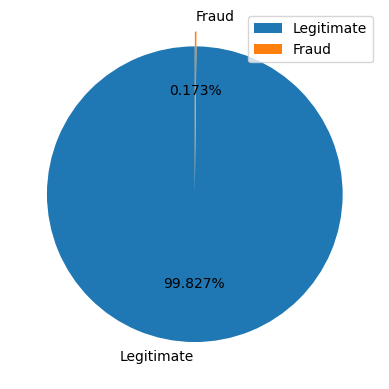

In [ ]:
Labels = ["Legitimate", "Fraud"]
Label_count = raw_df["Class"].value_counts().tolist()
explode = [0, 0.1]

plt.pie(Label_count, labels=Labels, autopct='%1.3f%%', explode=explode, startangle = 90)
plt.legend(loc="upper right")
plt.show()

In [ ]:
print(f"Number of Legitimate Transactions: {Label_count[0]}")
print(f"Number of Fraudulent Transactions: {Label_count[1]}")

Number of Legitimate Transactions: 284315
Number of Fraudulent Transactions: 492


#Data preprocessing


##Deleting duplicate values

In [ ]:
df = raw_df.copy()
df.drop(['Time'], axis=1, inplace=True)
df.drop_duplicates(inplace=True)

##Checking for outliers

###Using boxplot


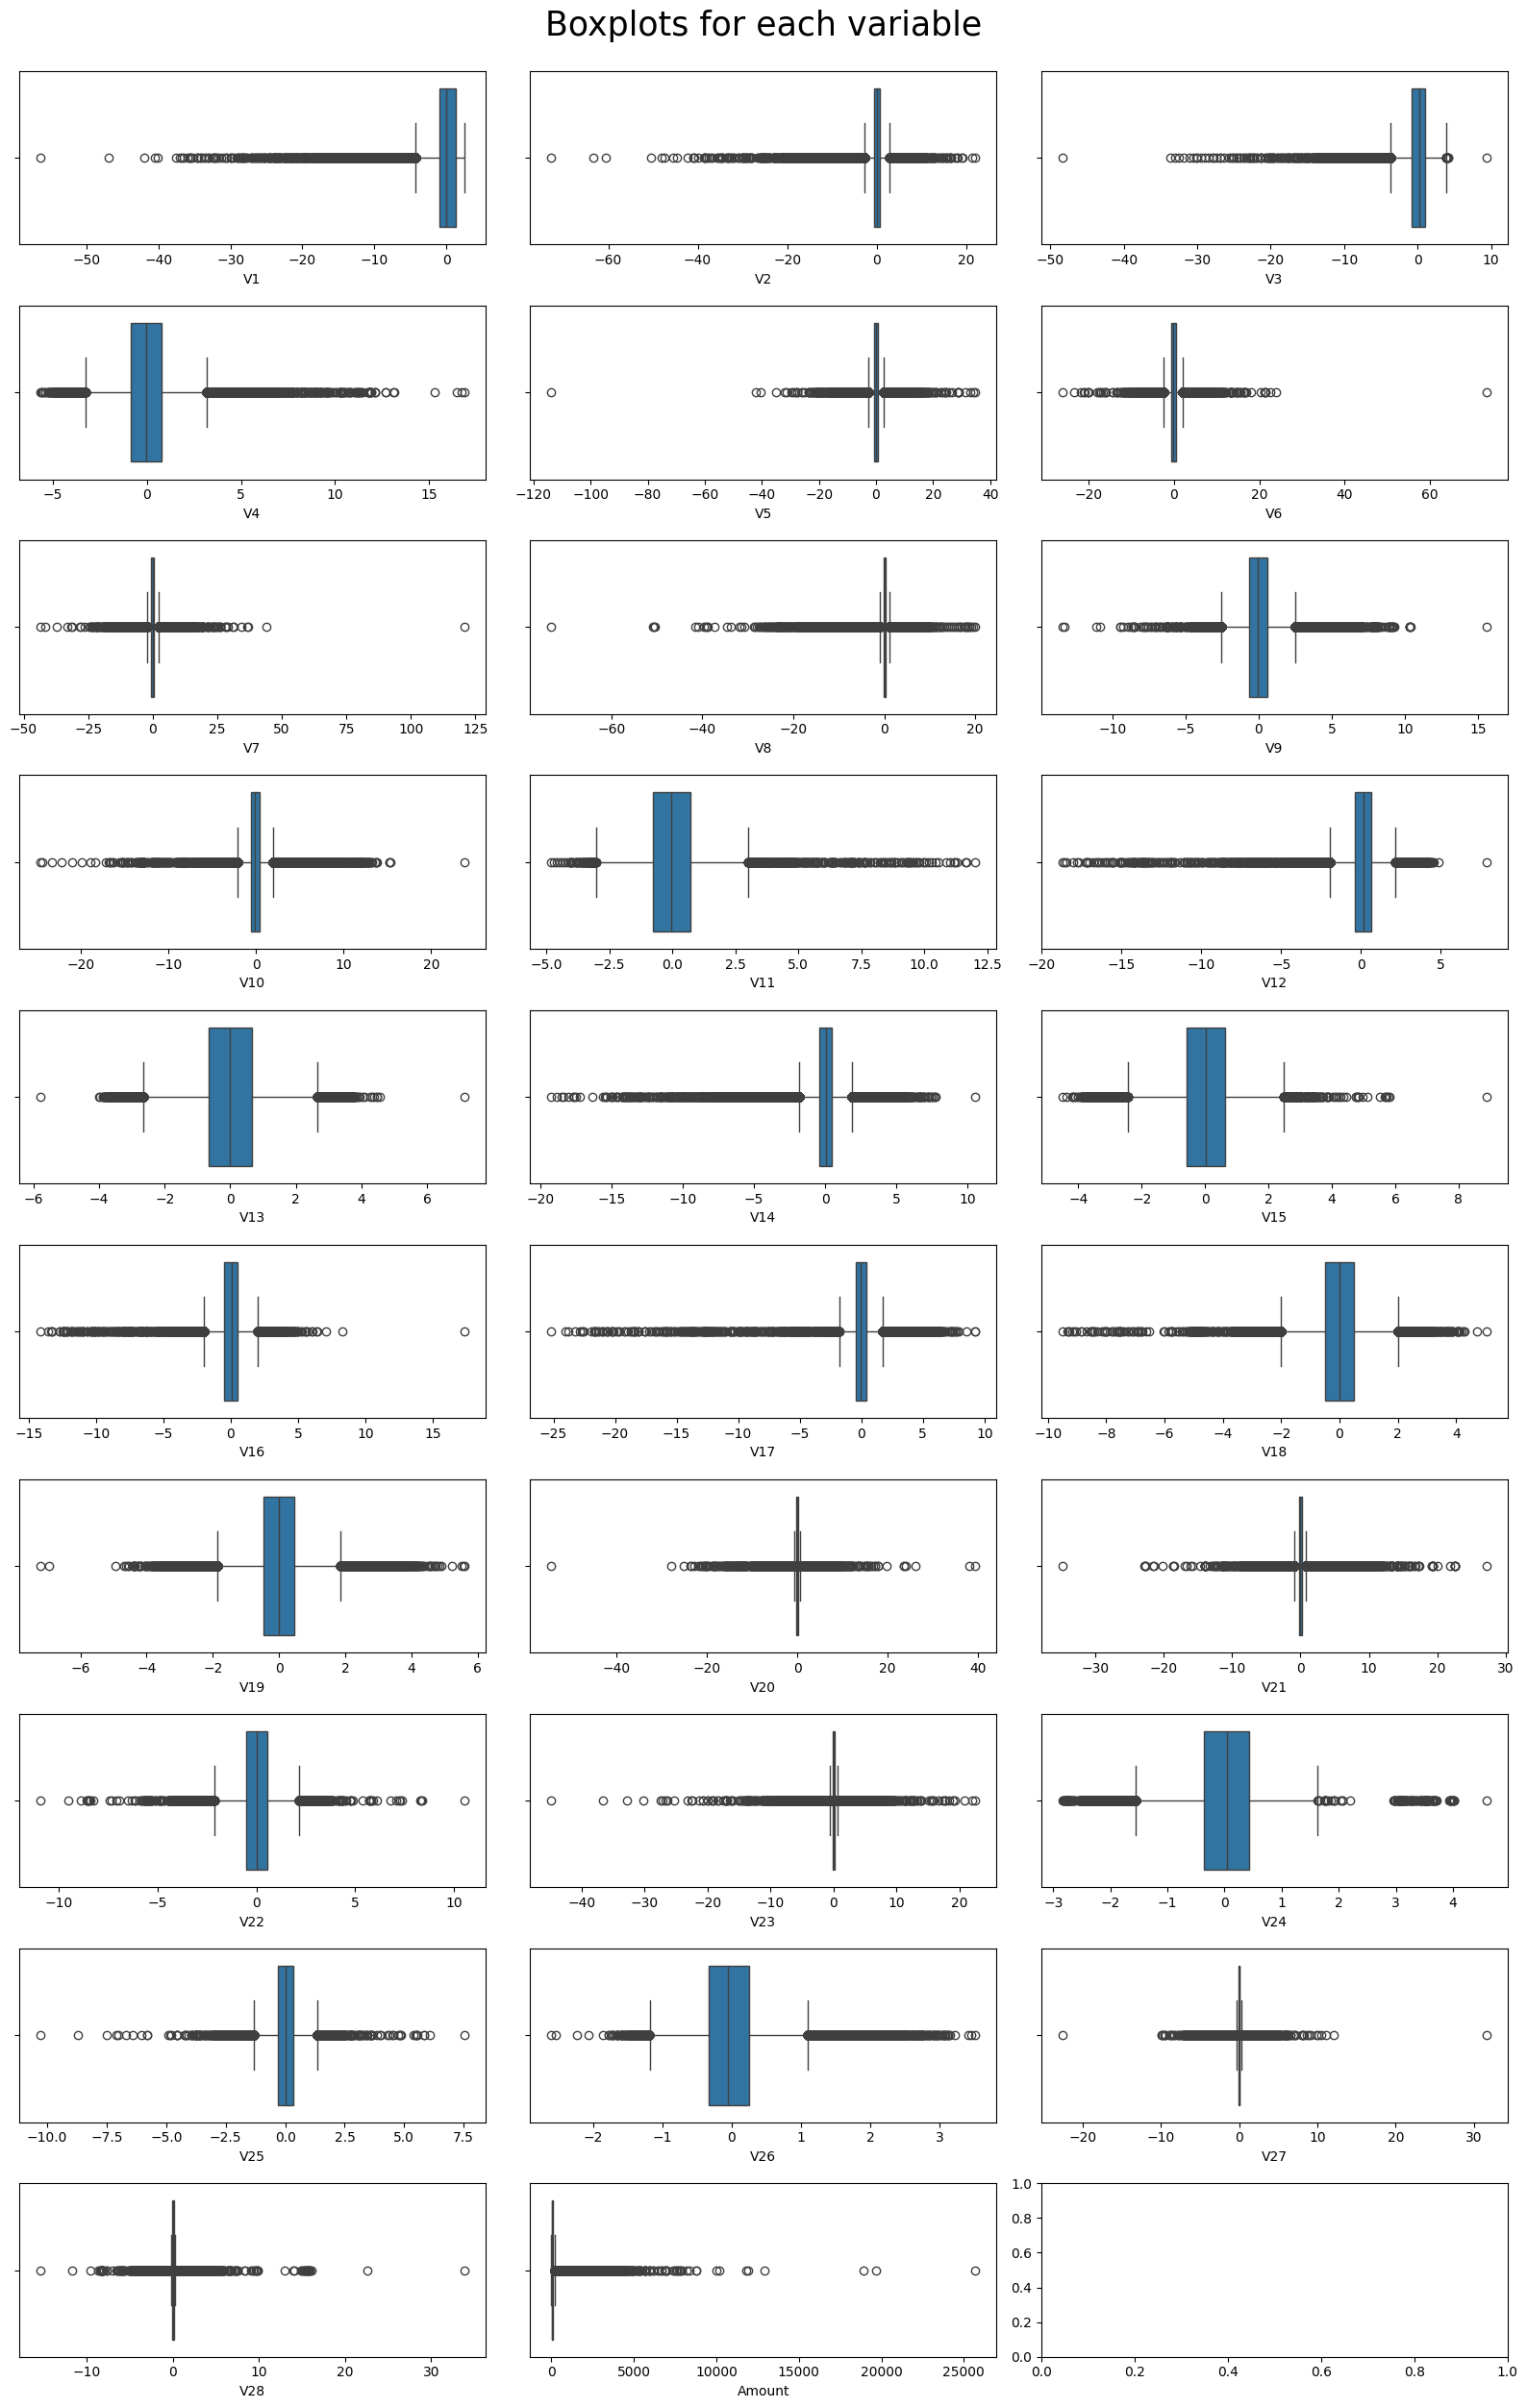

In [ ]:
fig, axes = plt.subplots(10, 3, figsize=(16, 25))
fig.suptitle('Boxplots for each variable', y = 1, size = 25)

for i, column in enumerate(df.columns[:-1]):
    sns.boxplot(x=df[column], ax=axes[i // 3, i % 3])

plt.tight_layout()
plt.show()


In [ ]:
def IQR_method(df,n,features):

    outlier_list = []

    for column in features:
        Q1 = np.percentile(df[column], 25)
        Q3 = np.percentile(df[column], 75)

        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR

        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step)].index
        outlier_list.extend(outlier_list_column)

    # selecting rows with more than n outliers
    outlier_list = Counter(outlier_list)
    multiple_outliers = list(k for k, v in outlier_list.items() if v > n)

    print(f"Total number of obervations exceeding the outlier limit: {len(multiple_outliers)}")

    return multiple_outliers

In [ ]:
numeric_columns = (list(df.loc[:, 'V1':'Amount']))
outliers = IQR_method(df, 1, numeric_columns)

df_outlier = df.drop(outliers, axis = 0).reset_index(drop = True)

Total number of obervations exceeding the outlier limit: 77555


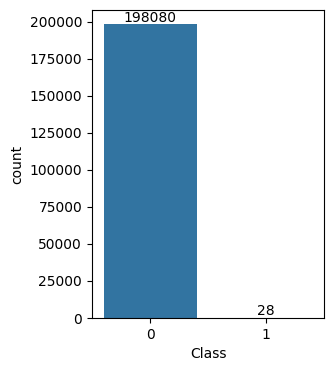

In [ ]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x="Class", data=df_outlier)
for i in ax.containers:
    ax.bar_label(i,)

##### After removal of outliers most of the obervations of fraudulent transactions are removed. It will hard to train the model with just 26 instances of minor class so we will train the model on whole data

# Spliting Data into train/test set

##### to ensure that the minority class will be divided we will use stratified splitting which will preserve the class proportions

In [ ]:
x = df.drop('Class', axis = 1)
y = df['Class']
print(x.shape)
print(y.shape)

(275663, 29)
(275663,)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size = 0.2, random_state = 3)

# Feature Scaling

In [ ]:
def Standard_scaler(df, col_names):
    features = df[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[col_names] = features

    return df

In [ ]:
col_names = ['Amount']
X_train = Standard_scaler(x_train.copy(), col_names)
X_test = Standard_scaler(x_test.copy(), col_names)

# Base Model (no sampling)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

#We are going to ensure that we have the same splits of the data every time.
#We can do this by creating a KFold object, kf, and passing cv=kf instead of the more common cv=5.

kf = StratifiedKFold(n_splits=5, shuffle=False)

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=13)
#cross_val_score(rf, X_train, y_train, cv=kf, scoring='recall')

In [ ]:
score = cross_val_score(rf, X_train, y_train, cv=kf, scoring='recall')
print("Cross Validation Recall scores are: {}".format(score))
print("Average Cross Validation Recall score: {}".format(score.mean()))

Cross Validation Recall scores are: [0.78666667 0.82666667 0.71052632 0.78947368 0.80263158]
Average Cross Validation Recall score: 0.7831929824561403


In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 10, 12],
    'random_state': [13]
}

grid_rf = GridSearchCV(rf, param_grid=params, cv=kf,
                          scoring='recall', verbose=3).fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_depth=4, n_estimators=50, random_state=13;, score=0.667 total time=  31.7s
[CV 2/5] END max_depth=4, n_estimators=50, random_state=13;, score=0.773 total time=  32.6s
[CV 3/5] END max_depth=4, n_estimators=50, random_state=13;, score=0.618 total time=  33.2s
[CV 4/5] END max_depth=4, n_estimators=50, random_state=13;, score=0.645 total time=  31.4s
[CV 5/5] END max_depth=4, n_estimators=50, random_state=13;, score=0.711 total time=  31.4s
[CV 1/5] END max_depth=4, n_estimators=100, random_state=13;, score=0.680 total time= 1.0min
[CV 2/5] END max_depth=4, n_estimators=100, random_state=13;, score=0.787 total time= 1.0min
[CV 3/5] END max_depth=4, n_estimators=100, random_state=13;, score=0.605 total time= 1.0min
[CV 4/5] END max_depth=4, n_estimators=100, random_state=13;, score=0.645 total time= 1.0min
[CV 5/5] END max_depth=4, n_estimators=100, random_state=13;, score=0.724 total time= 1.1min
[CV 1/5] END m

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:
print('Best parameters:', grid_rf.best_params_)
print('Best score:', grid_rf.best_score_)

Best parameters: {'max_depth': 12, 'n_estimators': 100, 'random_state': 13}
Best score: 0.7831578947368423


In [ ]:
y_pred = grid_rf.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
rf = RandomForestClassifier(max_depth = 12, n_estimators=100, random_state=13)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

rf_Recall = recall_score(y_test, y_pred)
rf_Precision = precision_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)
rf_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[55035     3]
 [   26    69]]


In [ ]:
ndf = [(rf_Recall, rf_Precision, rf_f1, rf_accuracy)]

rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
rf_score.insert(0, 'Random Forest with', 'No Under/Oversampling')
rf_score

,Random Forest with,Recall,Precision,F1 Score,Accuracy
0,No Under/Oversampling,0.726316,0.958333,0.826347,0.999474


## Random Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)

In [ ]:
x_over, y_over = ros.fit_resample(X_train, y_train)
print('Genuine:', y_over.value_counts()[0], '/', round(y_over.value_counts()[0]/len(y_over) * 100,2), '% of the dataset')
print('Frauds:', y_over.value_counts()[1], '/',round(y_over.value_counts()[1]/len(y_over) * 100,2), '% of the dataset')

Genuine: 220152 / 50.0 % of the dataset
Frauds: 220152 / 50.0 % of the dataset


In [ ]:
from imblearn.pipeline import Pipeline, make_pipeline

random_overs_pipeline = make_pipeline(RandomOverSampler(random_state=42),
                              RandomForestClassifier(n_estimators=100, random_state=13))
#cross_val_score(random_overs_pipeline, X_train, y_train, scoring='recall', cv=kf)

In [ ]:
score2 = cross_val_score(random_overs_pipeline, X_train, y_train, scoring='recall', cv=kf)
print("Cross Validation Recall Scores are: {}".format(score2))
print("Average Cross Validation Recall score: {}".format(score2.mean()))

Cross Validation Recall Scores are: [0.77333333 0.85333333 0.69736842 0.78947368 0.84210526]
Average Cross Validation Recall score: 0.7911228070175438


In [ ]:
new_params = {'randomforestclassifier__' + key: params[key] for key in params}
grid_over_rf = GridSearchCV(random_overs_pipeline, param_grid=new_params, cv=kf, scoring='recall',
                        return_train_score=True)
grid_over_rf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('randomoversampler',
                                        RandomOverSampler(random_state=42)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=13))]),
             param_grid={'randomforestclassifier__max_depth': [4, 6, 10, 12],
                         'randomforestclassifier__n_estimators': [50, 100, 200],
                         'randomforestclassifier__random_state': [13]},
             return_train_score=True, scoring='recall')

In [ ]:
print('Best parameters:', grid_over_rf.best_params_)
print('Best score:', grid_over_rf.best_score_)

Best parameters: {'randomforestclassifier__max_depth': 4, 'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__random_state': 13}
Best score: 0.8651578947368421


In [ ]:
y_pred = grid_over_rf.best_estimator_.named_steps['randomforestclassifier'].predict(X_test)

In [ ]:
random_overs_pipeline = make_pipeline(
    RandomOverSampler(random_state=42),
    RandomForestClassifier(n_estimators=100, random_state=13, max_depth=4)
)

random_overs_pipeline.fit(X_train, y_train)

y_pred = random_overs_pipeline.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
over_rf_Recall = recall_score(y_test, y_pred)
over_rf_Precision = precision_score(y_test, y_pred)
over_rf_f1 = f1_score(y_test, y_pred)
over_rf_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[54796   242]
 [   15    80]]


In [ ]:
ndf = [(over_rf_Recall, over_rf_Precision, over_rf_f1, over_rf_accuracy)]

over_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
over_rf_score.insert(0, 'Random Forest with', 'Random Oversampling')
over_rf_score

,Random Forest with,Recall,Precision,F1 Score,Accuracy
0,Random Oversampling,0.842105,0.248447,0.383693,0.995339


## SMOTE (Synthetic Minority Oversampling Technique)

In [ ]:
from imblearn.over_sampling import SMOTE

smote_pipeline = make_pipeline(SMOTE(random_state=42),
                              RandomForestClassifier(n_estimators=100, random_state=13))
#cross_val_score(smote_pipeline, X_train, y_train, scoring='recall', cv=kf)

In [ ]:
score3 = cross_val_score(smote_pipeline, X_train, y_train, scoring='recall', cv=kf)
print("Cross Validation Recall Scores are: {}".format(score3))
print("Average Cross Validation Recall score: {}".format(score3.mean()))

Cross Validation Recall Scores are: [0.78666667 0.89333333 0.69736842 0.82894737 0.85526316]
Average Cross Validation Recall score: 0.8123157894736842


In [ ]:
from sklearn.model_selection import GridSearchCV
params = {
    'n_estimators': [50],
    'max_depth': [4],
    'random_state': [13]
}
new_params = {'randomforestclassifier__' + key: params[key] for key in params}
smote_rf = GridSearchCV(smote_pipeline, param_grid=new_params, cv=kf, scoring='recall', verbose = 3,
                        return_train_score=True)
smote_rf.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END randomforestclassifier__max_depth=4, randomforestclassifier__n_estimators=50, randomforestclassifier__random_state=13;, score=(train=0.898, test=0.827) total time= 1.0min
[CV 2/5] END randomforestclassifier__max_depth=4, randomforestclassifier__n_estimators=50, randomforestclassifier__random_state=13;, score=(train=0.875, test=0.933) total time=  58.5s
[CV 3/5] END randomforestclassifier__max_depth=4, randomforestclassifier__n_estimators=50, randomforestclassifier__random_state=13;, score=(train=0.901, test=0.789) total time=  58.5s
[CV 4/5] END randomforestclassifier__max_depth=4, randomforestclassifier__n_estimators=50, randomforestclassifier__random_state=13;, score=(train=0.874, test=0.908) total time=  59.9s
[CV 5/5] END randomforestclassifier__max_depth=4, randomforestclassifier__n_estimators=50, randomforestclassifier__random_state=13;, score=(train=0.891, test=0.855) total time=  58.6s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=13))]),
             param_grid={'randomforestclassifier__max_depth': [4],
                         'randomforestclassifier__n_estimators': [50],
                         'randomforestclassifier__random_state': [13]},
             return_train_score=True, scoring='recall', verbose=3)

In [ ]:
print('Best parameters:', smote_rf.best_params_)
print('Best score:', smote_rf.best_score_)

Best parameters: {'randomforestclassifier__max_depth': 4, 'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__random_state': 13}
Best score: 0.8625263157894738


In [ ]:
y_pred = smote_rf.best_estimator_.named_steps['randomforestclassifier'].predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred)

smote_rf_Recall = recall_score(y_test, y_pred)
smote_rf_Precision = precision_score(y_test, y_pred)
smote_rf_f1 = f1_score(y_test, y_pred)
smote_rf_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[54784   254]
 [   16    79]]


In [ ]:
ndf = [(smote_rf_Recall, smote_rf_Precision, smote_rf_f1, smote_rf_accuracy)]

smote_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
smote_rf_score.insert(0, 'Random Forest with', 'SMOTE Oversampling')
smote_rf_score

,Random Forest with,Recall,Precision,F1 Score,Accuracy
0,SMOTE Oversampling,0.831579,0.237237,0.369159,0.995103


## Class weights in the models

In [ ]:
rfb = RandomForestClassifier(n_estimators=100, random_state=13, class_weight="balanced")

In [ ]:
score5 = cross_val_score(rfb, X_train, y_train, cv=kf, scoring='recall')
print("Cross Validation Recall scores are: {}".format(score5))
print("Average Cross Validation Recall score: {}".format(score5.mean()))

Cross Validation Recall scores are: [0.74666667 0.8        0.64473684 0.78947368 0.80263158]
Average Cross Validation Recall score: 0.756701754385965


In [ ]:
params = {
    'n_estimators': [50],
    'max_depth': [4],
    'random_state': [13]
}

grid_rfb = GridSearchCV(rfb, param_grid=params, cv=kf,
                          scoring='recall', verbose = 3, return_train_score=True).fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=4, n_estimators=50, random_state=13;, score=(train=0.898, test=0.827) total time=  27.6s
[CV 2/5] END max_depth=4, n_estimators=50, random_state=13;, score=(train=0.891, test=0.933) total time=  28.9s
[CV 3/5] END max_depth=4, n_estimators=50, random_state=13;, score=(train=0.901, test=0.776) total time=  26.9s
[CV 4/5] END max_depth=4, n_estimators=50, random_state=13;, score=(train=0.884, test=0.895) total time=  26.9s
[CV 5/5] END max_depth=4, n_estimators=50, random_state=13;, score=(train=0.891, test=0.855) total time=  26.9s


In [ ]:
y_pred = grid_rfb.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred)

grid_rfb_Recall = recall_score(y_test, y_pred)
grid_rfb_Precision = precision_score(y_test, y_pred)
grid_rfb_f1 = f1_score(y_test, y_pred)
grid_rfb_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[54876   162]
 [   15    80]]


In [ ]:
ndf = [(grid_rfb_Recall, grid_rfb_Precision, grid_rfb_f1, grid_rfb_accuracy)]

grid_rfb_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_rfb_score.insert(0, 'Random Forest with', 'Class weights')
grid_rfb_score

,Random Forest with,Recall,Precision,F1 Score,Accuracy
0,Class weights,0.842105,0.330579,0.474777,0.99679


## Performance comparison

In [ ]:
predictions = pd.concat([rf_score, over_rf_score, smote_rf_score, grid_rfb_score], ignore_index=True, sort=False)
predictions.sort_values(by=['Recall'], ascending=False)

,Random Forest with,Recall,Precision,F1 Score,Accuracy
1,Random Oversampling,0.842105,0.248447,0.383693,0.995339
3,Class weights,0.842105,0.330579,0.474777,0.996790
2,SMOTE Oversampling,0.831579,0.237237,0.369159,0.995103
0,No Under/Oversampling,0.726316,0.958333,0.826347,0.999474


## AUC ROC Curve

In [ ]:
from sklearn.metrics import roc_auc_score
ROCAUCscore = roc_auc_score(y_test, y_pred)
print(f"AUC-ROC Curve for Random Forest with Class weights: {ROCAUCscore:.4f}")

AUC-ROC Curve for Random Forest with Class weights: 0.9196


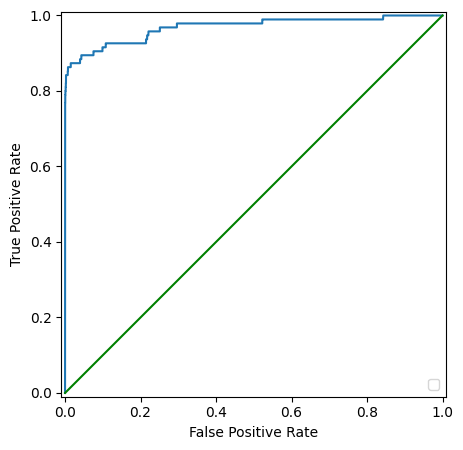

In [ ]:
y_proba = grid_rfb.predict_proba(X_test)

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
def plot_auc_roc_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')

plot_auc_roc_curve(y_test, y_proba[:, 1])
